In [1]:
import pandas as pd
import os
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, PC, MmhcEstimator
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from sklearn.model_selection import train_test_split
from sklearn import metrics as sk_mtr
from pgmpy.inference import VariableElimination

# Plot the Figures Inline
%matplotlib inline

### Load data

In [15]:
data_dir = '../data'
data_file = 'cmc.data'

data_path = os.path.join(data_dir, data_file)

In [16]:
data = pd.read_csv(data_path, header=None)

# setting column names
data.columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
    'wife_working', 'husband_occup', 'sol_index', 'media_exposure', 
    'class'
]

X = data[['wife_age', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
          'wife_working', 'husband_occup', 'sol_index', 'media_exposure']]
y = data[['class']]

### Helpers 

In [23]:
def plot_network(bn):
    plt.figure(figsize=(10, 10))
    pos=graphviz_layout(bn, prog='dot')
    nx.draw(
        bn,
        pos=pos,
        with_labels=True,
        node_color='white',
        edgecolors='black',
        node_size=8000,
        arrowsize=20,
    )
    plt.show()

### Discretization

In [18]:
def discritize(attribute,
               X,
               n_bins):
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    values = X[attribute].to_numpy()
    values = values.reshape((len(values),1))
    X[attribute+"_discrete"] = kbins.fit_transform(values)
    return X

In [19]:
X = discritize('wife_age',X,10)

In [20]:
X

,wife_age,wife_edu,husband_edu,n_children,wife_religion,wife_working,husband_occup,sol_index,media_exposure,wife_age_discrete
0,24,2,3,3,1,1,2,3,0,2.0
1,45,1,3,10,1,1,3,4,0,8.0
2,43,2,3,7,1,1,3,4,0,8.0
3,42,3,2,9,1,1,3,3,0,7.0
4,36,3,3,8,1,1,3,2,0,6.0
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,5.0
1469,33,4,4,3,1,1,1,4,0,5.0
1470,39,3,3,8,1,0,1,4,0,6.0
1471,33,3,3,4,1,0,2,2,0,5.0


In [21]:
X = X[['wife_age_discrete', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
          'wife_working', 'husband_occup', 'sol_index', 'media_exposure']]

### Bayesian Network - structures exploration

#### Tabu Search (score-based)

Performs local hill climb search to estimates the DAG structure that has optimal score, according to the scoring method supplied. Starts at model start_dag and proceeds by step-by-step network modifications until a local maximum is reached. Only estimates network structure, no parametrization.

**BIC score** 

The BIC/MDL score ("Bayesian Information Criterion", also "Minimal Descriptive Length") is a
log-likelihood score with an additional penalty for network complexity, to avoid overfitting.

  0%|          | 4/1000000 [00:00<42:38:08,  6.52it/s]


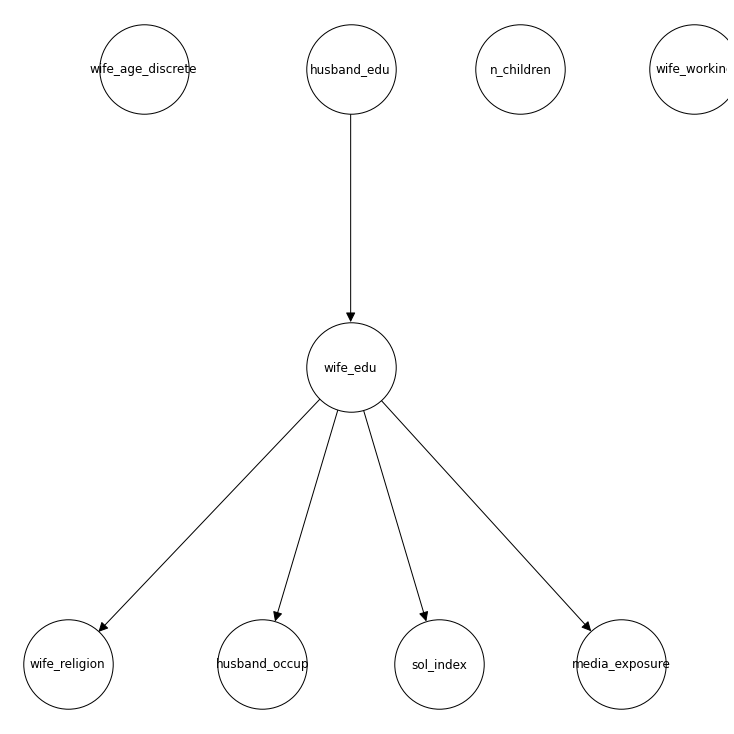

In [24]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BicScore(X))
plot_network(best_model)

**K2 score**

The K2 score is the result of setting all Dirichlet hyperparameters/pseudo_counts to 1.

  0%|          | 12/1000000 [00:01<26:25:26, 10.51it/s]


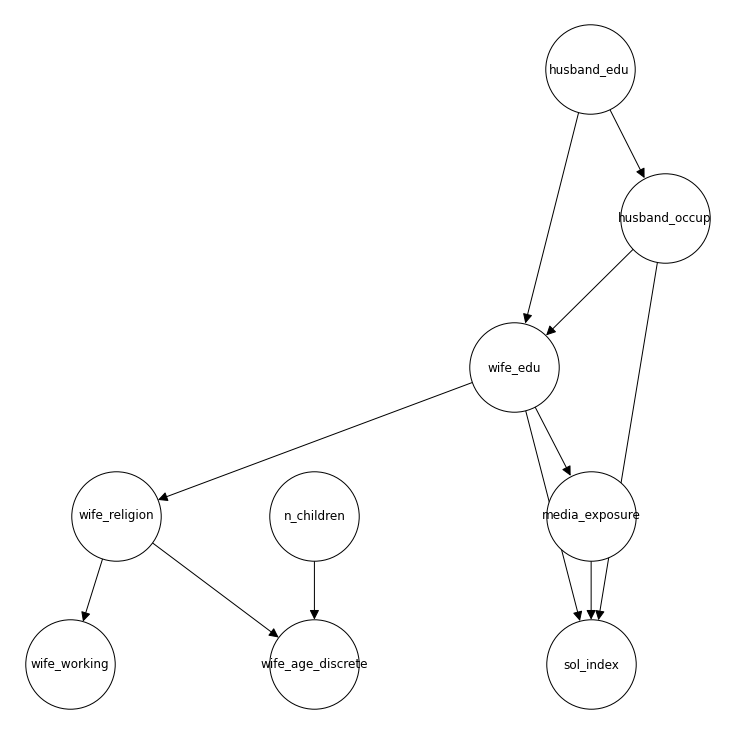

In [25]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=K2Score(X))
plot_network(best_model)

**BDeu score**

The BDeu score is the result of setting all Dirichlet hyperparameters/pseudo_counts to
`equivalent_sample_size/variable_cardinality`.

  0%|          | 8/1000000 [00:00<32:45:22,  8.48it/s]


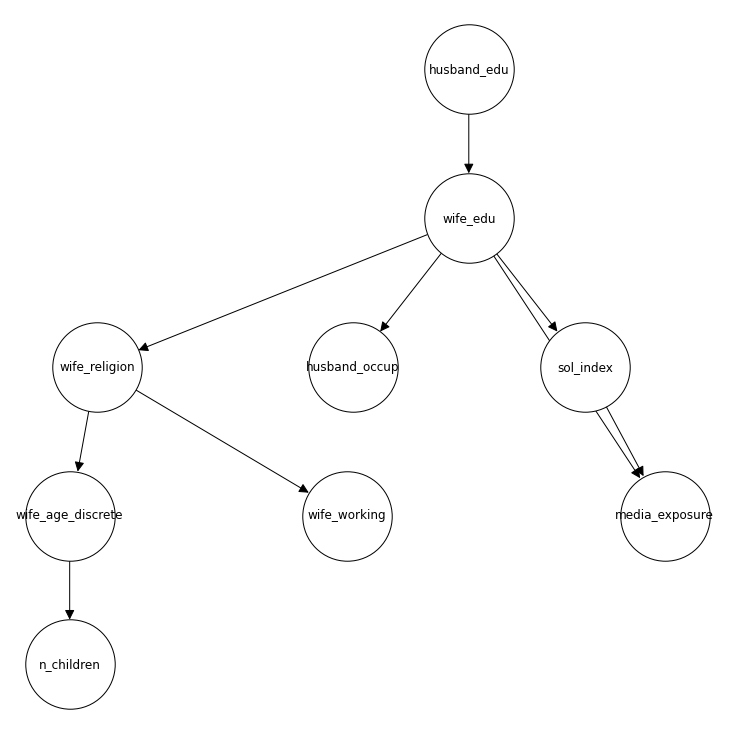

In [29]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BDeuScore(X))
plot_network(best_model)

#### PC (constraint-based)

Estimates a DAG/PDAG from the given dataset using the PC algorithm which is a constraint-based structure learning algorithm. The independencies in the dataset are identified by doing statistical independece test. This method returns a DAG/PDAG structure which is faithful to the independencies implied by the dataset

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:22<00:00,  3.88s/it]/Users/marcelc/Documents/10_sem/puma/lab/puma_venv/lib/python3.8/site-packages/pgmpy/estimators/PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


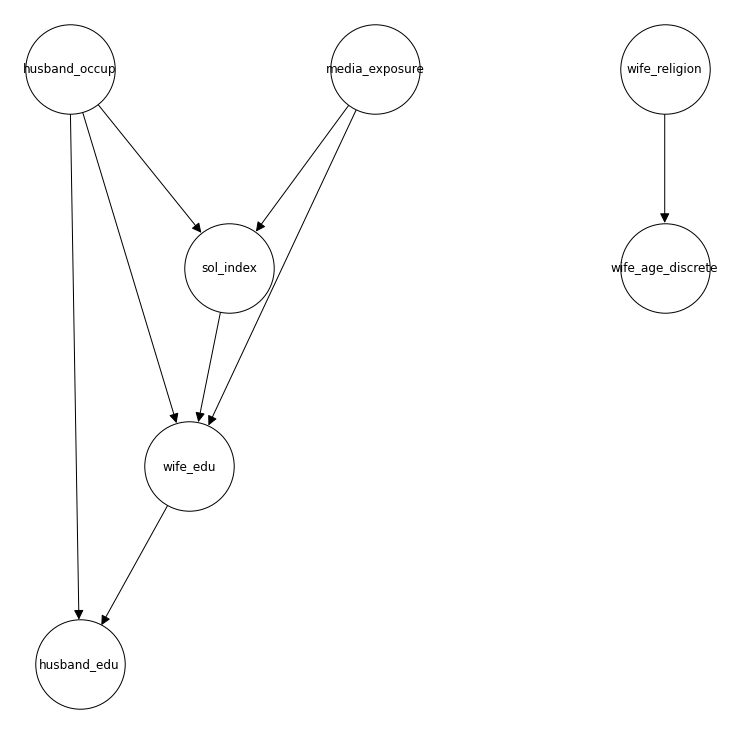

In [30]:
est = PC(X)
best_model = est.estimate()
plot_network(best_model)

#### Mmhc (hybrid)

First estimates a graph skeleton using MMPC and then orients the edges using score-based local search (hill climbing). Does not work in current lib version.

  0%|                                                                                      | 0/1000000 [00:00<?, ?it/s]


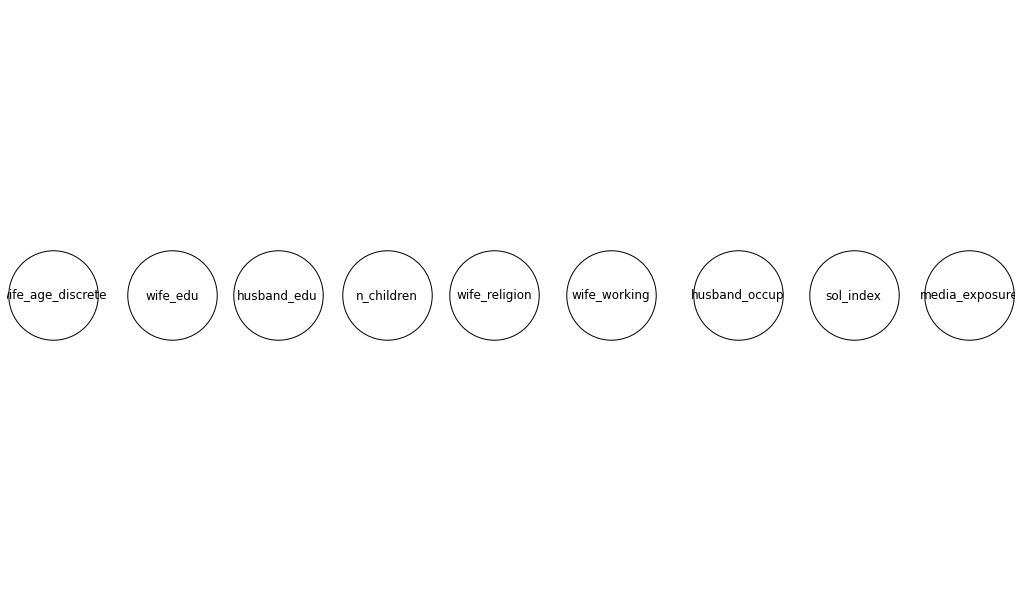

In [152]:
# not working

est = MmhcEstimator(X)
best_model = est.estimate(scoring_method=K2Score(X))
plot_network(best_model)

  0%|          | 1/1000000 [00:00<66:08:19,  4.20it/s]


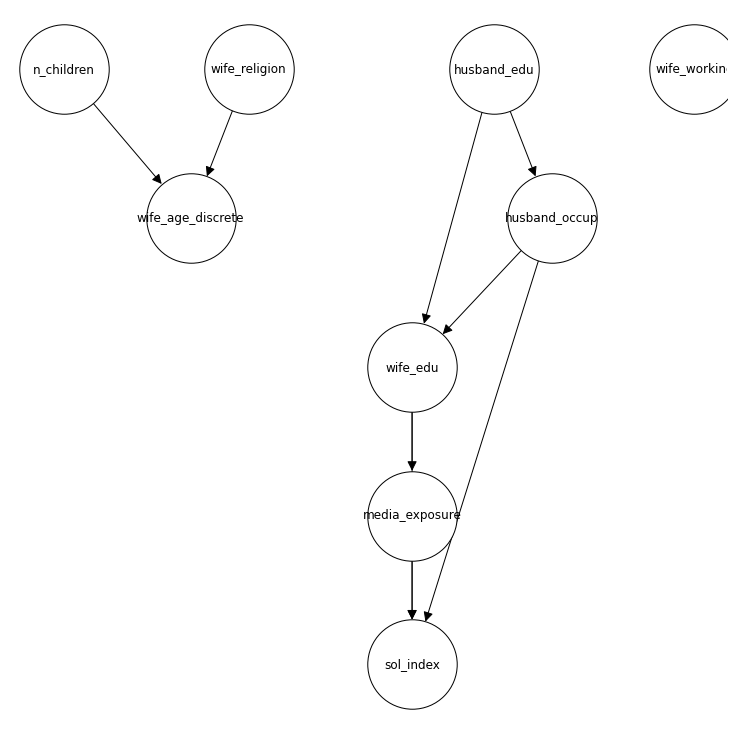

In [31]:
# mmhc_est = MmhcEstimator(data=X)
# mmhc_learned_model = mmhc_est.estimate(scoring_method=BDeuScore(data=df), tabu_length=100, significance_level=0.01)
# ręczna implementacja dwóch kroków
# mmpc_skleton = mmhc_est.mmpc(significance_level=0.01)

pc_est = PC(data=X)
skeleton, separating_sets = pc_est.build_skeleton(variant='parallel')

hc = HillClimbSearch(
    data=X, 
    scoring_method=BDeuScore(data=X)
)

pchc_learned_model = hc.estimate(
    tabu_length=100, 
    white_list=skeleton.to_directed().edges()
)

plot_network(pchc_learned_model)

### Bayesian Network empirical definition

In [32]:
model = BayesianModel([('wife_age_discrete', 'n_children'),   ('husband_edu', 'husband_occup'),   ('husband_edu', 'sol_index'),
                       ('wife_edu', 'sol_index'),  ('sol_index', 'media_exposure'),   ('wife_age_discrete', 'wife_working'),
                       ('wife_edu', 'wife_working'),  ('wife_working', 'sol_index'),  ('wife_working', 'n_children'),
                       ('husband_occup', 'n_children'),('husband_occup', 'sol_index')])
model.add_node('wife_religion')

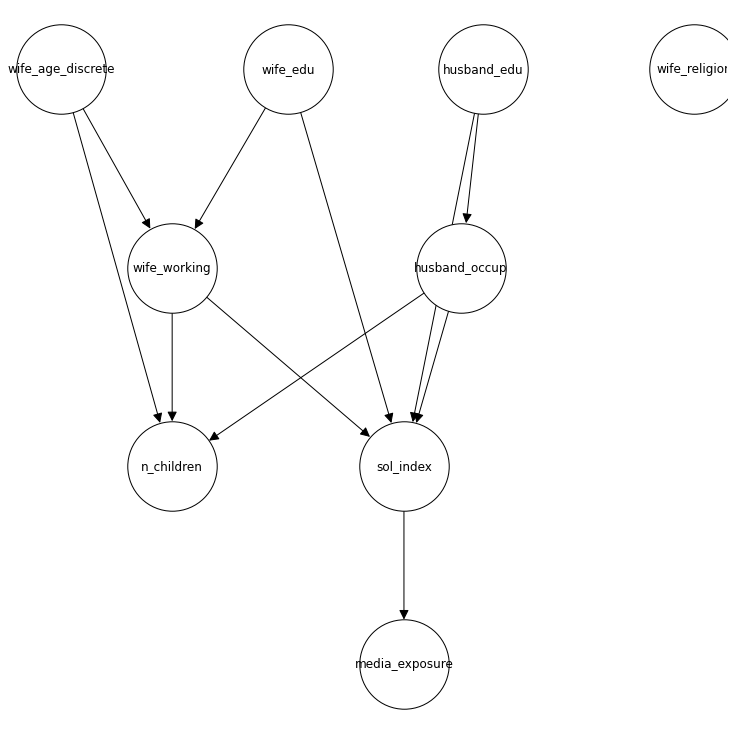

In [33]:
plot_network(model)

### Generated structures based on empirical exploration 

  0%|          | 12/1000000 [00:01<29:10:38,  9.52it/s]


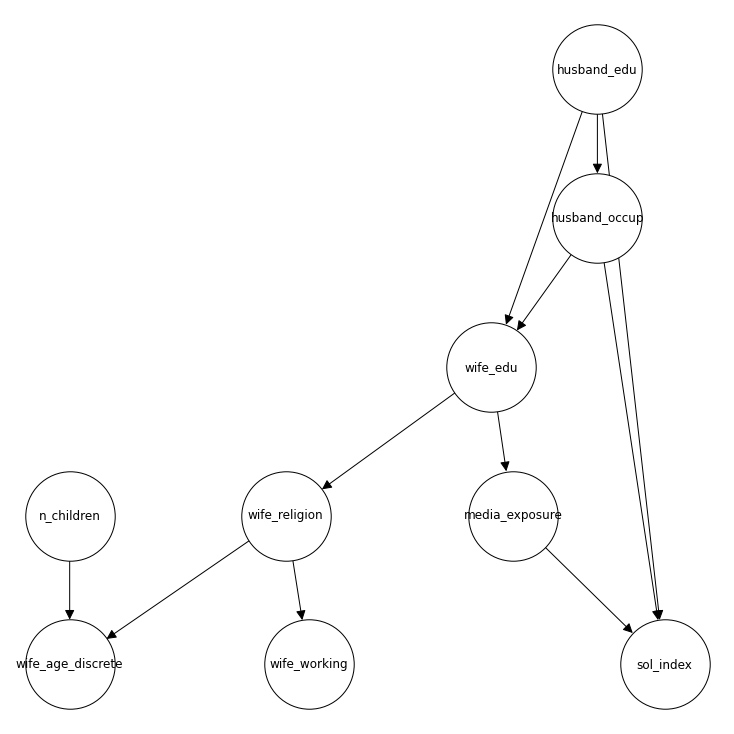

In [34]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=K2Score(X), start_dag = model)
plot_network(best_model)

  0%|          | 2/1000000 [00:00<124:47:44,  2.23it/s]


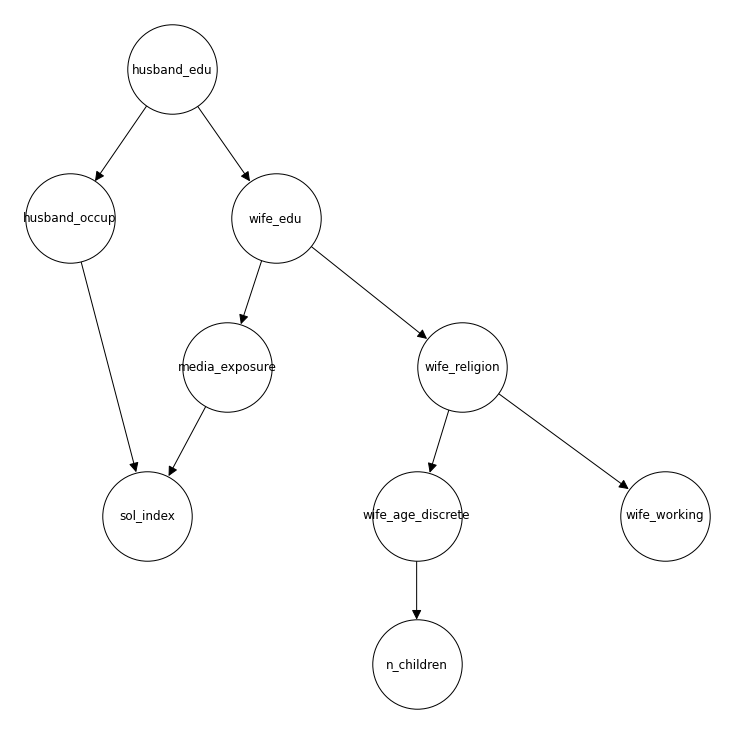

In [35]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BDeuScore(X), start_dag = model)
plot_network(best_model)

### Model exploration

In [179]:
model.get_independencies()

(wife_age_discrete ⟂ husband_occup, husband_edu, wife_edu, wife_religion)
(wife_age_discrete ⟂ husband_occup, wife_edu, wife_religion | husband_edu)
(wife_age_discrete ⟂ wife_religion | media_exposure)
(wife_age_discrete ⟂ husband_edu, wife_edu, husband_occup | wife_religion)
(wife_age_discrete ⟂ husband_occup, husband_edu, wife_religion | wife_working)
(wife_age_discrete ⟂ media_exposure, wife_religion | sol_index)
(wife_age_discrete ⟂ husband_occup, husband_edu, wife_religion | wife_edu)
(wife_age_discrete ⟂ wife_religion | n_children)
(wife_age_discrete ⟂ husband_edu, wife_edu, wife_religion | husband_occup)
(wife_age_discrete ⟂ wife_religion | husband_edu, media_exposure)
(wife_age_discrete ⟂ wife_edu, husband_occup | husband_edu, wife_religion)
(wife_age_discrete ⟂ wife_religion, husband_occup | wife_working, husband_edu)
(wife_age_discrete ⟂ media_exposure, wife_religion | husband_edu, sol_index)
(wife_age_discrete ⟂ wife_religion, husband_occup | husband_edu, wife_edu)
(wife_age

In [188]:
model.local_independencies('n_children')

(n_children ⟂ wife_working, husband_occup, sol_index, husband_edu, wife_edu, media_exposure, wife_religion | wife_age_discrete)

### Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Fit model

In [11]:
model = BayesianModel([('wife_age_discrete', 'n_children'),   ('husband_edu', 'husband_occup'),   ('husband_edu', 'sol_index'),
                       ('wife_edu', 'sol_index'),  ('sol_index', 'media_exposure'),   ('wife_age_discrete', 'wife_working'),
                       ('wife_edu', 'wife_working'),  ('wife_working', 'sol_index'),  ('wife_working', 'n_children'),
                       ('husband_occup', 'n_children'),('husband_occup', 'sol_index'),('n_children','class')])
model.add_node('wife_religion')

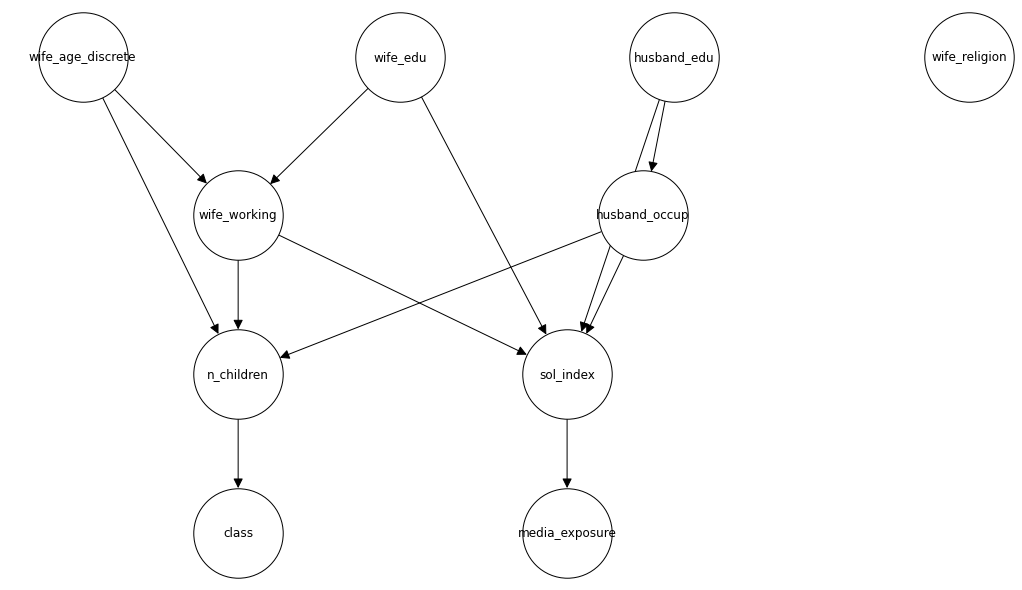

In [12]:
plot_network(model)

In [13]:
train_ds = pd.concat([X_train, y_train], axis=1) 
model.fit(data=train_ds, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')

Check model: True



In [14]:
def predict_pgmpy(model, X):
    ve = VariableElimination(model)
    y_pred = []
    #print(X)
    for idx, row in X.iterrows():
        #print(row)
        query = ve.map_query(['class'], dict(row),show_progress=False)
        y_pred.append(query['class'])
    return y_pred
    
y_pred = predict_pgmpy(model, X_test)

In [15]:
print(sk_mtr.classification_report(
        y_true=y_test,
        y_pred=y_pred,
    ))

              precision    recall  f1-score   support

           1       0.55      0.72      0.62       130
           2       0.11      0.01      0.03        71
           3       0.40      0.49      0.44        94

    accuracy                           0.47       295
   macro avg       0.35      0.41      0.36       295
weighted avg       0.39      0.47      0.42       295

